In [85]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# ---------------------------
# 1. Initialize Spark Session
# ---------------------------

"""Initialize the Spark session with Hive support."""
spark = SparkSession.builder.appName("FraudDetection").enableHiveSupport().getOrCreate()

# ---------------------------
# 2. Load Data from Hive
# ---------------------------

"""Load data from Hive table into a Spark DataFrame."""
hive_df= spark.sql("SELECT * FROM bigdata_nov_2024.sop_credit_trans")
hive_df.show(5)

+---+---------------------+--------------------+--------------+-----+----------+---------+------+--------------------+------------+-----+-----+-------+--------+----------+--------------------+----------+--------------------+----------+------------------+------------------+--------+---+----------+
| id|trans_date_trans_time|            merchant|      category|  amt|first_name|last_name|gender|              street|        city|state|  zip|    lat|    long|population|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|Age|      Date|
+---+---------------------+--------------------+--------------+-----+----------+---------+------+--------------------+------------+-----+-----+-------+--------+----------+--------------------+----------+--------------------+----------+------------------+------------------+--------+---+----------+
|896|  2020-06-21 17:25:01|fraud_Baumbach, F...|  shopping_net|72.23|    Joanna|   Hudson|     F|2924 Bobb

In [86]:
# Filter rows where is_fraud == 0 and limit to 10,000 rows
non_fraud_df = hive_df.filter(hive_df.is_fraud == 0).limit(10000)

# Filter rows where is_fraud == 1 (all rows)
fraud_df = hive_df.filter(hive_df.is_fraud == 1)

# Combine both DataFrames
hive_df = non_fraud_df.union(fraud_df)

# Show final data
hive_df.show()

+---+---------------------+--------------------+--------------+-----+----------+---------+------+--------------------+--------------+-----+-----+------------------+------------------+----------+--------------------+----------+--------------------+----------+------------------+------------------+--------+---+----------+
| id|trans_date_trans_time|            merchant|      category|  amt|first_name|last_name|gender|              street|          city|state|  zip|               lat|              long|population|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|Age|      Date|
+---+---------------------+--------------------+--------------+-----+----------+---------+------+--------------------+--------------+-----+-----+------------------+------------------+----------+--------------------+----------+--------------------+----------+------------------+------------------+--------+---+----------+
|896|  2020-06-21 17:25:01|fraud_Baum

In [87]:
for field in hive_df.schema.fields:
    print(f"Column: {field.name}, Type: {field.dataType}")

Column: id, Type: LongType
Column: trans_date_trans_time, Type: TimestampType
Column: merchant, Type: StringType
Column: category, Type: StringType
Column: amt, Type: DoubleType
Column: first_name, Type: StringType
Column: last_name, Type: StringType
Column: gender, Type: StringType
Column: street, Type: StringType
Column: city, Type: StringType
Column: state, Type: StringType
Column: zip, Type: LongType
Column: lat, Type: DoubleType
Column: long, Type: DoubleType
Column: population, Type: LongType
Column: job, Type: StringType
Column: dob, Type: DateType
Column: trans_num, Type: StringType
Column: unix_time, Type: LongType
Column: merch_lat, Type: DoubleType
Column: merch_long, Type: DoubleType
Column: is_fraud, Type: LongType
Column: Age, Type: IntegerType
Column: Date, Type: DateType


In [88]:
#checking balance of dataset
data=hive_df.groupBy('is_fraud').count()
data.show()

+--------+-----+
|is_fraud|count|
+--------+-----+
|       0|10000|
|       1| 2145|
+--------+-----+



In [89]:

# Selecting Relevant Features
feature_cols = ['amt', 'zip', 'population','Age']  # Adjust these based on your dataset

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Index the target column ('is_fraud') for classification
indexer = StringIndexer(inputCol='is_fraud', outputCol='label')

# Apply transformations
prepared_df = assembler.transform(hive_df)
prepared_df = indexer.fit(prepared_df).transform(prepared_df)


In [90]:

# ---------------------------
# 4. Build and Train Model
# ---------------------------
print("🤖 Training the model...")

# Split data into training and testing sets
print("📊 Splitting data into training and testing sets...")
train_df, test_df = prepared_df.randomSplit([0.8, 0.2], seed=42)
print(f"✅ Training Set: {train_df.count()} rows, Testing Set: {test_df.count()} rows")

# Define Logistic Regression Model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

model = lr.fit(train_df)

# Evaluate Model
predictions = model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol='label')
auc = evaluator.evaluate(predictions)
print(f"✅ Model AUC: {auc}")

# Display Predictions
predictions.select('features', 'label', 'prediction').show(10)



🤖 Training the model...
📊 Splitting data into training and testing sets...
✅ Training Set: 9735 rows, Testing Set: 2410 rows
✅ Model AUC: 0.8067926421404696
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[66.74,76366.0,23...|  0.0|       0.0|
|[59.89,77566.0,28...|  0.0|       0.0|
|[26.76,4287.0,322...|  0.0|       0.0|
|[98.42,71960.0,13...|  0.0|       0.0|
|[14.12,30009.0,16...|  0.0|       0.0|
|[36.6,27522.0,123...|  0.0|       0.0|
|[12.31,63829.0,11...|  0.0|       0.0|
|[241.23,85086.0,1...|  0.0|       0.0|
|[221.81,64470.0,1...|  0.0|       0.0|
|[61.37,1257.0,212...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



In [91]:
from pyspark.sql.functions import col

# Calculate TP, FP, FN, TN
tp = predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
fp = predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()
tn = predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()

# Calculate Precision, Recall, F1 Score
precision = tp / (tp + fp) 
recall = tp / (tp + fn) 
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"✅ Precision: {precision}")
print(f"✅ Recall: {recall}")
print(f"✅ F1 Score: {f1_score}")


✅ Precision: 0.889795918367347
✅ Recall: 0.47391304347826085
✅ F1 Score: 0.6184397163120567


In [92]:
# Show sample rows for each prediction class
print("✅ Sample rows where prediction is 1.0 (Fraudulent):")
predictions.filter(predictions['prediction'] == 1.0).show(5)



✅ Sample rows where prediction is 1.0 (Fraudulent):
+----+---------------------+--------------------+-------------+------+----------+---------+------+--------------------+------------+-----+-----+-------+---------+----------+--------------------+----------+--------------------+----------+---------+-----------+--------+---+----------+--------------------+-----+--------------------+--------------------+----------+
|  id|trans_date_trans_time|            merchant|     category|   amt|first_name|last_name|gender|              street|        city|state|  zip|    lat|     long|population|                 job|       dob|           trans_num| unix_time|merch_lat| merch_long|is_fraud|Age|      Date|            features|label|       rawPrediction|         probability|prediction|
+----+---------------------+--------------------+-------------+------+----------+---------+------+--------------------+------------+-----+-----+-------+---------+----------+--------------------+----------+---------------

In [93]:
# ---------------------------
# 5. Predict Single Record
# ---------------------------
print("🔍 Predicting a single record...")

# Example Record for Prediction
sample_data = [(100.0, 84002,50000, 25)]  # Example: 'amt', 'zip', 'population','Age'
sample_df = spark.createDataFrame(sample_data, ['amt', 'zip', 'population','Age'])

# Assemble Sample Record
sample_df = assembler.transform(sample_df)

# Make Prediction
sample_prediction = model.transform(sample_df)

result = sample_prediction.select("prediction")
result



if result == 1.0:
    print("🚨 This transaction is predicted to be FRAUDULENT!")
else:
    print("✅ This transaction is predicted to be LEGITIMATE.")



🔍 Predicting a single record...
✅ This transaction is predicted to be LEGITIMATE.


In [94]:
sample_prediction.show()

+-----+-----+----------+---+--------------------+--------------------+--------------------+----------+
|  amt|  zip|population|Age|            features|       rawPrediction|         probability|prediction|
+-----+-----+----------+---+--------------------+--------------------+--------------------+----------+
|100.0|84002|     50000| 25|[100.0,84002.0,50...|[2.40720632156801...|[0.91737517349220...|       0.0|
+-----+-----+----------+---+--------------------+--------------------+--------------------+----------+



## EDA


In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convert to Pandas DataFrame
hive_pandas_df = hive_df.select('is_fraud','amt','zip','Age','population').toPandas()




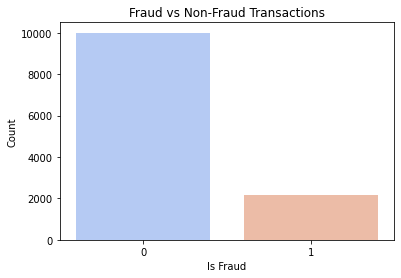

In [96]:
# Bar plot for fraud distribution
#plt.figure(figsize=(8, 5))
sns.countplot(data=hive_pandas_df, x='is_fraud', palette='coolwarm')
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

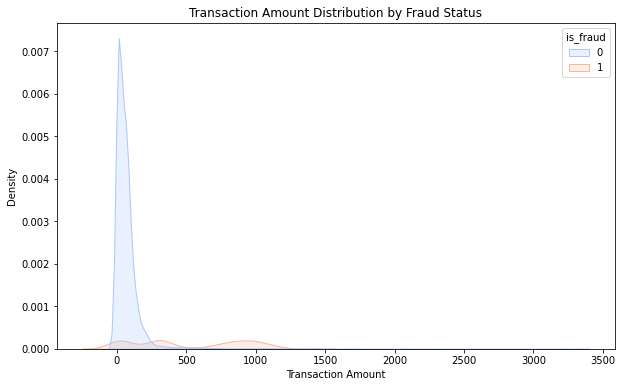

In [97]:
# KDE Plot for transaction amounts
plt.figure(figsize=(10, 6))
sns.kdeplot(data=hive_pandas_df, x='amt', hue='is_fraud', fill=True, palette='coolwarm')
plt.title('Transaction Amount Distribution by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.show()


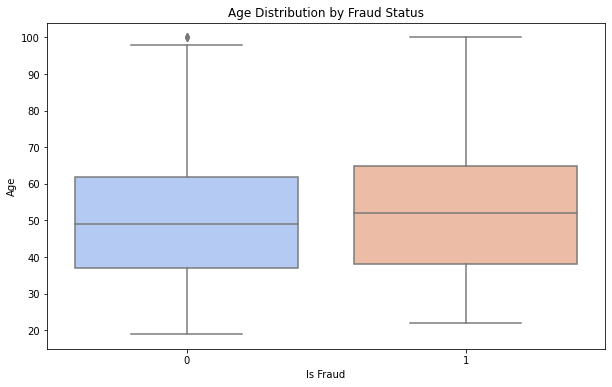

In [98]:
# Boxplot for Age
plt.figure(figsize=(10, 6))
sns.boxplot(data=hive_pandas_df, x='is_fraud', y='Age', palette='coolwarm')
plt.title('Age Distribution by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Age')
plt.show()


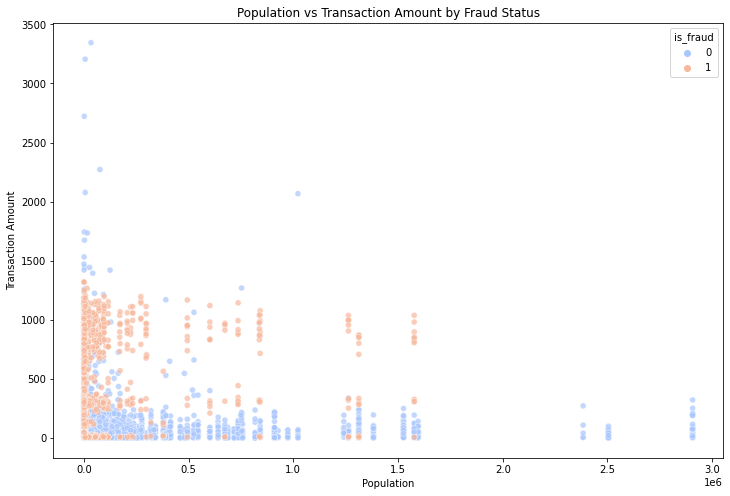

In [99]:
# Scatter plot for Population and Fraud
plt.figure(figsize=(12, 8))
sns.scatterplot(data=hive_pandas_df, x='population', y='amt', hue='is_fraud', palette='coolwarm', alpha=0.7)
plt.title('Population vs Transaction Amount by Fraud Status')
plt.xlabel('Population')
plt.ylabel('Transaction Amount')
plt.show()


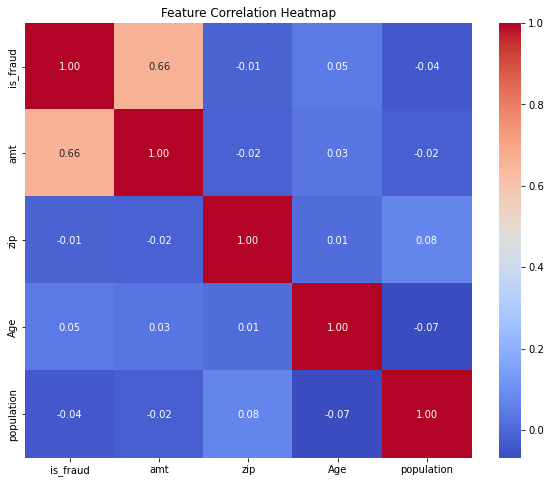

In [100]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(hive_pandas_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


In [101]:
print(spark.sparkContext._jsc)  # Java Spark Context should not be None


org.apache.spark.api.java.JavaSparkContext@758af388


In [103]:
# ---------------------------
# 6. Stop Spark Session
# ---------------------------
spark.stop()